<a href="https://colab.research.google.com/github/kocavs/DL_MiniProject/blob/JD5226Branch/DL_Mini_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet For CIFAR0-10

In [29]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
#import renet

import torchvision
import torchvision.transforms as transforms

import os
from torchsummary import summary
import torch.utils.data as data

### Model Construction

In [30]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()

        # Branch 1: 1x1 convolution
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        # Branch 2: 1x1 convolution followed by 3x3 convolution
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)

        return torch.cat([branch1_out, branch2_out], 1)

class InceptionResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 1)
        self.layer2 = self._make_layer(128, 128, 2, stride=2)
        self.layer3 = self._make_layer(256, 256, 2, stride=2)
        self.layer4 = self._make_layer(512, 512, 1, stride=2)
        

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        for _ in range(num_blocks):
            layers.append(InceptionModule(in_channels, out_channels))
            in_channels = out_channels * 2

        if stride == 2:
            layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Initialize the Inception-ResNet model

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = InceptionResNet(num_classes=10).to(device)

In [32]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,160
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]           4,160
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
  InceptionModule-14            [-1, 12

Construction Complete

### Data Preprocessing

In [33]:
class Cutout(object):
  """Randomly mask out one or more patches from an image.
  Args:
      n_holes (int): Number of patches to cut out of each image.
      length (int): The length (in pixels) of each square patch.
  """
  def __init__(self, n_holes, length):
      self.n_holes = n_holes
      self.length = length

  def __call__(self, img):
      """
      Args:
          img (Tensor): Tensor image of size (C, H, W).
      Returns:
          Tensor: Image with n_holes of dimension length x length cut out of it.
      """
      h = img.size(1)
      w = img.size(2)

      mask = np.ones((h, w), np.float32)

      for n in range(self.n_holes):
          y = np.random.randint(h)
          x = np.random.randint(w)

          y1 = np.clip(y - self.length // 2, 0, h)
          y2 = np.clip(y + self.length // 2, 0, h)
          x1 = np.clip(x - self.length // 2, 0, w)
          x2 = np.clip(x + self.length // 2, 0, w)

          mask[y1: y2, x1: x2] = 0.

      mask = torch.from_numpy(mask)
      mask = mask.expand_as(img)
      img = img * mask

      return img

In [34]:
def load_CIFAR10(batch_size, train_ratio):

  ROOT = './data'
  trainset = torchvision.datasets.CIFAR10(
      root = ROOT,
      train = True, 
      download = True
  )

  # Compute means and standard deviations
  means = trainset.data.mean(axis=(0,1,2)) / 255
  stds = trainset.data.std(axis=(0,1,2)) / 255
  #print(means, stds)

  # Preprocess setting
  transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=means, std=stds),
      Cutout(n_holes=1, length=16)
  ])
  transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=means, std=stds)
  ])

  # Load the dataset
  trainset = torchvision.datasets.CIFAR10(
      root = ROOT, 
      train = True, 
      download = True, 
      transform = transform_train
  )
  testset = torchvision.datasets.CIFAR10(
      root = ROOT, 
      train = False, 
      download = True, 
      transform = transform_test
  )

  # Split trainset for validset
  n_train = int(len(trainset) * train_ratio)
  n_valid = len(trainset) - n_train
  train_dataset, valid_dataset = data.random_split(trainset, [n_train, n_valid])
  
  # Build dataloader
  train_iterator = data.DataLoader(train_dataset, batch_size, shuffle=True)
  valid_iterator = data.DataLoader(valid_dataset, batch_size)
  test_iterator = data.DataLoader(testset, batch_size)

  return train_iterator, valid_iterator, test_iterator

In [35]:
trainloader, validloader, testloader = load_CIFAR10(batch_size=256, train_ratio=1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [36]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.5,
    patience=5,
    min_lr=0.000001
)

In [37]:
def validate(validloader):
    # Validation
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(validloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        valid_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return valid_loss/total, 100.*correct/total

In [38]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted==targets).sum()/targets.size(0)

    train_loss = train_loss/len(trainloader)
    train_acc = 100.*correct/len(trainloader)

    # validation
    #valid_loss, valid_acc = validate(validloader)
    valid_loss = 0
    valid_acc = 0
    scheduler.step(train_loss)

    return train_loss, train_acc, valid_loss, valid_acc

In [39]:
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)

            correct += (predicted==targets).sum()/targets.size(0)

    # Save checkpoint.
    acc = 100.*correct/len(testloader)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    return test_loss/len(testloader), acc


In [40]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(start_epoch, start_epoch+150):
    train_loss, train_acc, valid_loss, valid_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    print("Epoch: ", epoch)
    print(f'\tTrain Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%')
    print(f'\tValid Loss: {valid_loss:.5f} | Valid Acc: {valid_acc:.2f}%')
    print(f'\t Test Loss: {test_loss:.5f} | Test. Acc: {test_acc:.2f}%')

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

Saving..
Epoch:  0
	Train Loss: 3.23152 | Train Acc: 15.44%
	Valid Loss: 0.00000 | Valid Acc: 0.00%
	 Test Loss: 2.15984 | Test. Acc: 18.11%
Saving..
Epoch:  1
	Train Loss: 1.94518 | Train Acc: 24.92%
	Valid Loss: 0.00000 | Valid Acc: 0.00%
	 Test Loss: 1.72990 | Test. Acc: 32.49%
Saving..
Epoch:  2
	Train Loss: 1.78894 | Train Acc: 31.36%
	Valid Loss: 0.00000 | Valid Acc: 0.00%
	 Test Loss: 1.65878 | Test. Acc: 36.05%
Saving..
Epoch:  3
	Train Loss: 1.65688 | Train Acc: 37.97%
	Valid Loss: 0.00000 | Valid Acc: 0.00%
	 Test Loss: 1.52599 | Test. Acc: 42.97%
Saving..
Epoch:  4
	Train Loss: 1.53724 | Train Acc: 42.81%
	Valid Loss: 0.00000 | Valid Acc: 0.00%
	 Test Loss: 1.38150 | Test. Acc: 49.64%
Saving..
Epoch:  5
	Train Loss: 1.43700 | Train Acc: 47.27%
	Valid Loss: 0.00000 | Valid Acc: 0.00%
	 Test Loss: 1.28028 | Test. Acc: 53.77%
Saving..
Epoch:  6
	Train Loss: 1.34955 | Train Acc: 50.64%
	Valid Loss: 0.00000 | Valid Acc: 0.00%
	 Test Loss: 1.25881 | Test. Acc: 54.44%
Epoch:  7
	Tr

-------------------------------------------------

Evaluation:

In [41]:
def type_changer(data):
  for i in range(len(data)):
    if not isinstance(data[i], float):
      data[i]=data[i].cpu()
  return data

def plot_figure(train_data, valid_data, name):

  train_data = type_changer(train_data)
  valid_data = type_changer(valid_data)
  train_data = np.array(train_data) 
  valid_data = np.array(valid_data)

  fig, ax = plt.subplots(figsize = (5, 3))
  ax.plot(train_data, color='blue', label='Training '+name)
  ax.plot(valid_data, color='red', label='Valid '+name+' 1') 
  ax.set(title=name+" over epochs", xlabel='Epoch',ylabel=name) 
  ax.legend()
  fig.show()

<ipython-input-41-53a7f56575d7>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


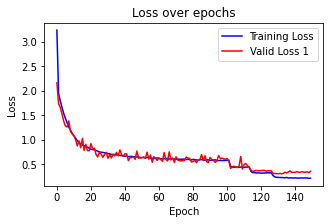

In [42]:
plot_figure(train_loss_list, test_loss_list, 'Loss')

<ipython-input-41-53a7f56575d7>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


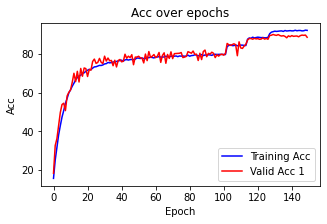

In [43]:
plot_figure(train_acc_list, test_acc_list, 'Acc')